In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as ssp
import scipy.sparse.linalg as sla
from scipy.linalg import sqrtm
from IPython.display import Image

In [2]:
N = 200 # number of timesteps
T = 20 # time will vary from 0 to T with stepsize h
ts = np.linspace(0,T,N+1)
h = T/N
gamma = .05 # damping, 0 is no damping
g = 9.8

n = 6   # state size
m = 3   # control size

I3 = ssp.eye(3)

A = ssp.bmat([[I3, (1-gamma*h/2)*h*I3], \
              [None,   (1-gamma*h)*I3]])
B = ssp.bmat([[h**2/2*I3],
              [     h*I3]])
b = np.array([0,0,-0.5*g*h**2,0,0,-g*h])

x_0 = np.array([500,200,2000,40,-10,-300])

In [ ]:
x_0.shape

In [ ]:
Image("../../Images/Instruction.png")

$$\begin{bmatrix} 1 & 2 & 3 \\ 4 & 5 & 6 \\ 7 & 8 & 9 \end{bmatrix}$$

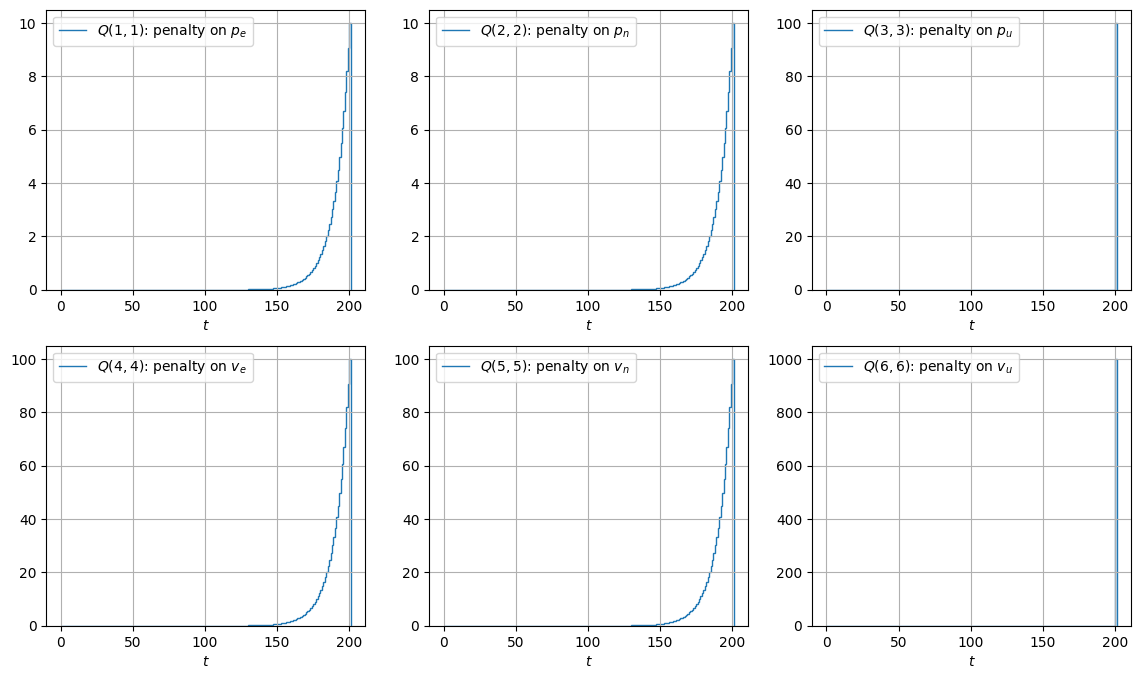

In [3]:
Q = []
R = []
Q_tilde = []
R_tilde = []
for t in range(N):
  Qt = np.exp(-(N-t)/10)*ssp.diags([10,10,  0,100,100,   0])
  Rt = ssp.eye(m)
  Q.append(Qt)
  R.append(Rt)
Q.append(ssp.diags([ 10,10,100,100,100,1000]))

labels = [r'$p_e$',r'$p_n$',r'$p_u$',r'$v_e$',r'$v_n$',r'$v_u$',
          r'$u_e$',r'$u_n$',r'$u_u$']

plt.figure(figsize=(14,8), dpi=100)
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.stairs([q.toarray()[i,i] for q in Q], label=rf'$Q({i+1},{i+1})$: penalty on {labels[i]}')
  plt.legend()
  plt.grid()
  plt.xlabel(r'$t$')
plt.show()

In [4]:
np.exp(-(N-t)/10)*ssp.diags([10,10,  0,100,100,   0])

<6x6 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements (1 diagonals) in DIAgonal format>

In [ ]:
# draw plots
def draw_plots(t1,x1,u1,t2=[],x2=[],u2=[]):
  # t1: time, (N+1,)-vector
  # x1: state trajectory, 6x(N+1) matrix
  # u1: control vector, 3xN matrix
  # t2, x2, u2: optional for comparing two trajectories, size same as above

  labels = [r'$p_e$',r'$p_n$',r'$p_u$',r'$v_e$',r'$v_n$',r'$v_u$',
            r'$u_e$',r'$u_n$',r'$u_u$']
  plt.figure(figsize=(14,9), dpi=100)
  for i in range(6):
    plt.subplot(3,3,i+1)
    plt.plot(t1,x1[i],label=labels[i])
    if len(t2):
      plt.plot(t2,x2[i])
    plt.legend()
    plt.grid()
  for i in range(3):
    plt.subplot(3,3,i+7)
    plt.plot(t1[:-1],u1[i],label=labels[i+6])
    if len(t2):
      plt.plot(t2[:-1],u2[i])
    plt.xlabel(r'$t$')
    plt.legend()
    plt.grid()
  plt.show()
  return

# draw 3D plot
def draw_3d_traj(x1,u1,x2=[],u2=[]):
  # x1: state trajectory, 6x(N+1) matrix
  # u1: control vector, 3xN matrix
  # x2, u2: optional for comparing two trajectories, size same as above

  fig = plt.figure(figsize=(10,10), dpi=100)
  ax  = fig.add_subplot(projection='3d')
  ax.view_init(elev=10, azim=-75, roll=0)
  _ = 10

  N = x1.shape[1]-1
  ax.plot(*x1[:3,:])
  if len(x2):
    ax.plot(*x2[:3,:])
  for i in range(0, N, 10):
    __ = np.linalg.norm(u1[:,i])/200
    ax.quiver(x1[0,i],x1[1,i],x1[2,i],-u1[0,i]*_,-u1[1,i]*_,-u1[2,i]*_, \
              color='magenta', linewidths=1, arrow_length_ratio = 0)
    ax.quiver(x1[0,i],x1[1,i],x1[2,i],u1[0,i]/__,u1[1,i]/__,u1[2,i]/__, \
              color='gray', linewidths=1, arrow_length_ratio = 0)
    if len(x2):
      __ = np.linalg.norm(u2[:,i])/200
      ax.quiver(x2[0,i],x2[1,i],x2[2,i],-u2[0,i]*_,-u2[1,i]*_,-u2[2,i]*_, \
                color='red', linewidths=1, arrow_length_ratio = 0)
      ax.quiver(x2[0,i],x2[1,i],x2[2,i],u2[0,i]/__,u2[1,i]/__,u2[2,i]/__, \
                color='black', linewidths=1, arrow_length_ratio = 0)

  th = np.linspace(0,2*np.pi)
  ax.plot(100*np.cos(th),100*np.sin(th),0,alpha=0.5,color='green')
  ax.plot(200*np.cos(th),200*np.sin(th),0,alpha=0.5,color='green')
  ax.set_xlabel(r'$p_e$')
  ax.set_ylabel(r'$p_n$')
  ax.set_zlabel(r'$p_u$')
  ax.axis('equal')
  plt.show()
  return

In [ ]:
# make 3D animation

from celluloid import Camera
from matplotlib import rc

def make_3d_anim(x1,u1,x2=[],u2=[],playback_speed=2):
  # x1: state trajectory, 6x(N+1) matrix
  # u1: control vector, 3xN matrix
  # x2, u2: optional for comparing two trajectories, size same as above

  fig = plt.figure(figsize=(10,10), dpi=100)
  ax = fig.add_subplot(projection='3d')
  ax.view_init(elev=10, azim=-75, roll=0)
  _ = 10

  N = x1.shape[1]-1
  camera = Camera(fig)
  for i in range(0,N,playback_speed):
    ax.plot(*x1[:3,:], alpha=0.2)
    if len(x2):
      ax.plot(*x2[:3,:], alpha=0.2)
    __ = np.linalg.norm(u1[:,i])/200
    ax.plot(x1[0,:i+1],x1[1,:i+1],x1[2,:i+1])
    ax.quiver(x1[0,i],x1[1,i],x1[2,i],-u1[0,i]*_,-u1[1,i]*_,-u1[2,i]*_, \
              color='magenta', linewidths=2, arrow_length_ratio = 0)
    ax.quiver(x1[0,i],x1[1,i],x1[2,i],u1[0,i]/__,u1[1,i]/__,u1[2,i]/__, \
              color='gray', linewidths=4, arrow_length_ratio = 0)
    if len(x2):
      __ = np.linalg.norm(u2[:,i])/200
      ax.plot(x2[0,:i+1],x2[1,:i+1],x2[2,:i+1])
      ax.quiver(x2[0,i],x2[1,i],x2[2,i],-u2[0,i]*_,-u2[1,i]*_,-u2[2,i]*_, \
                color='red', linewidths=2, arrow_length_ratio = 0)
      ax.quiver(x2[0,i],x2[1,i],x2[2,i],u2[0,i]/__,u2[1,i]/__,u2[2,i]/__, \
                color='black', linewidths=4, arrow_length_ratio = 0)

    th = np.linspace(0,2*np.pi)
    ax.plot(100*np.cos(th),100*np.sin(th),0,alpha=0.5,color='green')
    ax.plot(200*np.cos(th),200*np.sin(th),0,alpha=0.5,color='green')
    ax.set_xlabel(r'$p_e$')
    ax.set_ylabel(r'$p_n$')
    ax.set_zlabel(r'$p_u$')
    ax.axis( 'equal')

    camera.snap()

  plt.close()
  anim = camera.animate(blit=False, interval=100)
  rc('animation', html='jshtml')
  return anim

soft landing LQR by least squares

(Problem 1) Find the optimal maneuver acceration for the above LQR problem via least squares solutions. Report the terminal position and the terminal velocity at touchdown.

In [ ]:
G = A
_ = A
for i in range(N-1):
    _@=A
    G=ssp.vstack((G,_))

H=ssp.vstack((ssp.eye(n),G.tocsr()[:-n,:]))@B

for i in range(N-1):
    _=ssp.vstack((ssp.csr_matrix((n,m)),H[:-n,-m:]))
    H=ssp.hstack((H,_))

p=b
_=b
for I in range(N-1):
    _=A.dot(_)+b
    p=np.hstack((p,_))

Q_tilde = ssp.block_diag([sqrtm(_.toarray()) for _ in Q[1:]])
R_tilde = ssp.block_diag([sqrtm(_.toarray()) for _ in R])

A_tilde = ssp.bmat(([Q_tilde@H],[R_tilde]))
b_tilde = np.hstack((Q_tilde.dot(G.dot(x_0)+p),np.zeros(m*N)))

u_hat=sla.lsqr(A_tilde,-b_tilde,atol=1e-12,btol=1e-12) [0]

u_ls = u_hat.reshape(N,m).T
x_ls = np.zeros((n,N+1))
x_ls[:,0] = x_0

for t in range(N):
    x_ls[:,t+1] = A.dot(x_ls[:,t])+B.dot(u_ls[:,t])+b

print(f'terminal position: {x_ls[:3,-1]}')
print(f'terminal velocity: {x_ls[3:,-1]}')

In [ ]:
# draw plots
draw_plots(ts,x_ls,u_ls)
draw_3d_traj(x_ls,u_ls)

In [ ]:
# make 3D animation
make_3d_anim(x_ls,u_ls,playback_speed=2)

soft landing LQR by Riccati recursion via dynamic programming

(Problem 2) Find the optimal maneuver acceration for the above LQR problem by Riccati recursion via dynamic programming. Compare your solution with the least squares solution obtained from above.

In [ ]:
P = [ [] for _ in range(N+1) ]
q = [ [] for _ in range(N+1) ]
K = [ [] for _ in range(N) ]
l = [ [] for _ in range(N) ]
u_dp = np.zeros((m,N))
x_dp = np.zeros((n,N+1))
x_dp[:,0]=x_0
P[N] = Q[N]
q[N] = np.zeros(n)
for k in range(N-1,-1,-1):
    BTPB_R_inv_BT = sla.inv(B.T@P[k+1]@B+R[k])@B.T
    Pb_q = P[k+1]@b + q[k+1]
    K[k] = -BTPB_R_inv_BT@P[k+1]@A
    l[k] = -BTPB_R_inv_BT@(Pb_q)
    A_BK = A+ B@K[k]
    P[k] = Q[k]+A.T@P[k+1]@(A_BK)
    q[k] = (A_BK.T)@(Pb_q)
for i in range(N):
    u_dp[:,i] = K[i]@x_dp[:,i] + l[i]
    x_dp[:,i+1] = A.dot(x_dp[:,i])+B.dot(u_dp[:,i])+b 

In [ ]:
# plots
draw_plots(ts,x_ls,u_ls,ts,x_dp,u_dp)
draw_3d_traj(x_ls,u_ls,x_dp,u_dp)

In [ ]:
# make 3D animation
make_3d_anim(x_ls,u_ls,x_dp,u_dp,playback_speed=2)

Disturbance sensitivity

(Problem 3) Analyze the sensitivity of the two solutions to the random disturbance, by applying the two solution on the the following dynamic system. Apply the two control solutions on the rocket system under random gust: $$xt+1=Axt+But+wt+b$$
where $wt=(0,0,0,w_{\text{e}},t,w_{\text{e}}n,t,w_{\text{u}},t)$ represents the disturbance from random gust at time step t, and the gust disturbance components $w_{\text{e}},t, w_{\text{n}},t, w_{\text{u}},t$ are zero mean identically and independently distributed (IID) Gaussian random variables with variance given by $(pu,t/500)2$ (the gust intensity increasing with altitude). Simulate the stochastic system several times to check consistency.

w<sub>e</sub>,t, w<sub>n</sub>,t, w<sub>u</sub>

In [ ]:
np.random.seed(36)
w=np.zeros((n,N))
w[3:6,:]=np.random.randn(3,N)

x_ls=np.zeros((n,N+1))
x_ls[:,0]=x_0

for t in range(N):
    x_ls[:,t+1] = A.dot(x_ls[:,t])+B.dot(u_ls[:,t])+b+ w[:,t]*(x_ls[2,t]/500)

u_dp=np.zeros((m,N))
x_dp=np.zeros((n,N+1))
x_dp[:,0]=x_0

for t in range(N):
    u_dp[:,t]=K[t]@x_dp[:,t]+l[t]
    x_dp[:,t+1]=A.dot(x_dp[:,t])+B.dot(u_dp[:,t])+b+ w[:,t]*(x_dp[2,t]/500)
    
print(f'terminal position (DP): {x_dp[:3,-1]}')

In [ ]:
# plots
draw_plots(ts,x_ls,u_ls,ts,x_dp,u_dp)
draw_3d_traj(x_ls,u_ls,x_dp,u_dp)

In [ ]:
# make 3D animation
make_3d_anim(x_ls,u_ls,x_dp,u_dp,playback_speed=2)

Design your own trajectory

(Problem 4) Redesign $Q_{\text{0}},…,Q_{\text{N}}$ and possibly $R_{\text{0}},…,R_{\text{N−1}}$ so that the new trajectory looks prettier, safer, and also fuel efficient.